В рамках проекта в отделе цифровых технологий интернет-магазина «В один клик» мы будем разрабатывать решение для персонализации предложений постоянным клиентам с целью увеличения их покупательской активности.

Для начала мы проведем анализ данных, доступных у нас о постоянных клиентах, их предпочтениях, истории покупок и поведении на сайте магазина. Этот анализ поможет нам лучше понять наших клиентов, их предпочтения и потребности.

На основе полученных данных мы разработаем модель персонализации предложений. Модель будет использовать алгоритмы машинного обучения и анализа данных для определения наиболее релевантных предложений для каждого клиента. Мы учтем такие факторы, как предпочтения, история покупок, сезонные и акционные предложения, а также данные, связанные с поведением клиента на сайте.

Для реализации персонализированных предложений мы будем использовать различные инструменты и технологии, включая базы данных для хранения и управления клиентскими данными, алгоритмы машинного обучения для обработки и анализа данных, а также систему управления контентом для динамического формирования предложений.

После создания модели персонализации предложений мы проведем тестирование и оптимизацию решения. Мы будем анализировать результаты и корректировать модель, чтобы повысить ее эффективность и точность в предлагаемых предложениях.

Наша цель - создать решение, которое позволит магазину «В один клик» повысить покупательскую активность постоянных клиентов путем предоставления им персонализированных предложений. Это поможет удерживать клиентов, улучшить их опыт покупок и увеличить общую прибыль магазина.

# Загрузка данных

Обновим или установим необходимые пакеты Python для анализа данных:

In [1]:
!pip install phik -q
!pip install --upgrade scikit-learn scipy -q
!pip install shap -q
!pip install --upgrade shap -q
!pip install scikit-learn==1.1.3 -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.56.0 requires numpy<1.23,>=1.18, but you have numpy 1.26.4 which is incompatible.


In [2]:
!pip install matplotlib -U -q 

Импортируем необходимые библиотеки:

In [3]:
import os
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np
import phik
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
import shap

Загрузим данные в датафреймы:

In [4]:
def load_data(file_path, delimiter=','):
    # Проверка существования файла по указанному пути
    if os.path.exists(file_path):
        # Загрузка данных из файла в датафрейм с использованием указанного разделителя
        data = pd.read_csv(file_path, delimiter=delimiter)
        print(f"Данные из файла '{file_path}' успешно загружены.")
        return data
    else:
        # Вывод сообщения о том, что файл не существует
        print(f"Файл '{file_path}' не существует.")
        return None

In [5]:
market_file = load_data('/datasets/market_file.csv')
market_money = load_data('/datasets/market_money.csv')
market_time = load_data('/datasets/market_time.csv')
money = load_data('/datasets/money.csv', delimiter=';')

Данные из файла '/datasets/market_file.csv' успешно загружены.
Данные из файла '/datasets/market_money.csv' успешно загружены.
Данные из файла '/datasets/market_time.csv' успешно загружены.
Данные из файла '/datasets/money.csv' успешно загружены.


Создадим список из датафреймов:

In [6]:
dataframes = [market_file, market_money, market_time, money]

In [7]:
df_names= ['market_file', 'market_money', 'market_time', 'money']

Переименуем все столбцы в змеиный регистр:

In [8]:
def rename_columns_to_snake_case(dataframes):
    # Проход по каждому датафрейму в списке
    for df in dataframes:
        # Преобразование названий столбцов к змеиному регистру
        df.columns = [
            # Если в названии столбца есть текст в скобках, выполняется преобразование
            re.findall(r'\((.*?)\)', column)[0].lower().replace(' ', '_').replace(',', '')\
                .replace('%', '_в_процентах').replace('-', '_')
                if re.findall(r'\((.*?)\)', column)  # Проверка на наличие текста в скобках
                else column.lower().replace(' ', '_').replace(',', '').replace('%', '_в_процентах').replace('-', '_')
            for column in df.columns  # Проход по каждому столбцу в датафрейме
        ]

In [9]:
rename_columns_to_snake_case(dataframes)

Выведем общую информацию для датафреймов:

In [10]:
def dataframes_info(dataframes):
    for i, df in enumerate(dataframes):
        print(f"Информация о датафрейме {df_names[i]}:\n")
        # Общая информация о датафрейме
        display(df.info())
        # Первые 5 строк датафрейма
        #display(df.head())

In [11]:
dataframes_info(dataframes)

Информация о датафрейме market_file:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   покупательская_активность            1300 non-null   object 
 2   тип_сервиса                          1300 non-null   object 
 3   разрешить_сообщать                   1300 non-null   object 
 4   маркет_актив_6_мес                   1300 non-null   float64
 5   маркет_актив_тек_мес                 1300 non-null   int64  
 6   длительность                         1300 non-null   int64  
 7   акционные_покупки                    1300 non-null   float64
 8   популярная_категория                 1300 non-null   object 
 9   средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  неоплаченные_продукты_штук_квартал   1300 non-null   int64

None

Информация о датафрейме market_money:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   период   3900 non-null   object 
 2   выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


None

Информация о датафрейме market_time:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


None

Информация о датафрейме money:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       1300 non-null   int64 
 1   прибыль  1300 non-null   object
dtypes: int64(1), object(1)
memory usage: 20.4+ KB


None

In [12]:
def dataframes_head(dataframes):
    for i, df in enumerate(dataframes):
        print(f"Первые 5 строк датафрейма {df_names[i]}:\n")
        # Первые 5 строк датафрейма
        display(df.head())
        print(f"\n")

In [13]:
dataframes_head(dataframes)

Первые 5 строк датафрейма market_file:



,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2




Первые 5 строк датафрейма market_money:



,id,период,выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6




Первые 5 строк датафрейма market_time:



,id,период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13




Первые 5 строк датафрейма money:



,id,прибыль
0,215348,"0,98"
1,215349,"4,16"
2,215350,"3,13"
3,215351,"4,87"
4,215352,"4,21"


Были успешно загружены данные из внешних файлов в четыре датафрейма. 

Выполнена предобработка данных:

- Столбцы переименованы в snake_case нотацию для стандартизации и удобства дальнейшей работы с данными
- Получена общая информация о датафреймах и выведены их первые строки

Теперь имеется четыре датафрейма с загруженными данными, прошедшими предварительную подготовку. Таким образом, подготовлена рабочая среда для дальнейшего объединения, анализа и моделирования многофакторных данных.

# Предобработка данных

Заменим типы данных в датафреймах:

In [14]:
def dtypes_change(dataframes):
    for df in dataframes:
        # Выбираем только столбцы с типом данных object
        object_columns = df.select_dtypes(include='object').columns
    
        # Замена запятых на точки во всех столбцах object
        for col in object_columns:
            df.loc[:, col] = df[col].str.replace(',', '.')
        
            # Изменение типа на float, если возможно
            try:
                df.loc[:, col] = df[col].astype(float)
            except ValueError:
                pass

In [15]:
dtypes_change(dataframes)

In [16]:
def print_unique_values(dataframes):
    for i, df in enumerate(dataframes):
        string_columns = df.select_dtypes(include='object').columns
        if len(string_columns) == 0:
            print(f"В датафрейме {df_names[i]} нет столбцов строкового типа.\n")
        else:
            print(f"Уникальные значения в датафрейме {df_names[i]} для каждого столбца строкового типа:\n")
            for column in string_columns:
                unique_values = df[column].unique()
                print(f"Столбец {column}:")
                print(unique_values)
                print('\n')

In [17]:
print_unique_values(dataframes)

Уникальные значения в датафрейме market_file для каждого столбца строкового типа:

Столбец покупательская_активность:
['Снизилась' 'Прежний уровень']


Столбец тип_сервиса:
['премиум' 'стандартт' 'стандарт']


Столбец разрешить_сообщать:
['да' 'нет']


Столбец популярная_категория:
['Товары для детей' 'Домашний текстиль' 'Косметика и аксесуары'
 'Техника для красоты и здоровья' 'Кухонная посуда'
 'Мелкая бытовая техника и электроника']


Уникальные значения в датафрейме market_money для каждого столбца строкового типа:

Столбец период:
['препредыдущий_месяц' 'текущий_месяц' 'предыдущий_месяц']


Уникальные значения в датафрейме market_time для каждого столбца строкового типа:

Столбец период:
['текущий_месяц' 'предыдцщий_месяц']


В датафрейме money нет столбцов строкового типа.



In [18]:
# Замена значения "стандартт" на "стандарт" в столбце "тип_сервиса"
market_file['тип_сервиса'] = market_file['тип_сервиса'].replace('стандартт', 'стандарт')

In [19]:
# Замена значения "предыдцщий_месяц" на "предыдущий_месяц" в столбце "период"
market_time['период'] = market_time['период'].replace('предыдцщий_месяц', 'предыдущий_месяц')

Выполнена предобработка данных в нескольких шагах:

- Заменили типы данных, где нужно. 

- Обнаружены и исправлены ошибки в написании значений:
   - "стандартт" заменено на "стандарт"
   - "предыдцщий_месяц" заменено на "предыдущий_месяц"

Таким образом, выполнена чистка и стандартизация данных перед их дальнейшим объединением и анализом, что позволит избежать ошибок на последующих этапах обработки.

# Исследовательский анализ данных

In [20]:
def plot_histograms(df):
    numeric_columns = df.select_dtypes(include='number').columns

    # Исключение столбца 'id'
    numeric_columns = numeric_columns.drop('id', errors='ignore')

    num_plots = len(numeric_columns)
    num_rows = (num_plots + 1) // 2  # Вычисление количества строк

    fig, axes = plt.subplots(num_rows, 2, figsize=(15, 5 * num_rows))
    fig.tight_layout(pad=5.0)  # Увеличение промежутка между графиками

    for i, column in enumerate(numeric_columns):
        row = i // 2  # Вычисление текущей строки
        col = i % 2   # Вычисление текущего столбца

        ax = axes[row, col] if num_rows > 1 else axes[col]  # Получение текущей оси

        # Вычисление количества "bins" на основе количества уникальных значений
        bins = min(10, len(df[column].unique()))

        active = df.loc[df['покупательская_активность'] == 'Прежний уровень', column]
        reduced = df.loc[df['покупательская_активность'] == 'Снизилась', column]

        ax.hist(active, bins=bins, alpha=0.5, label='Прежний уровень')
        ax.hist(reduced, bins=bins, alpha=0.5, label='Снизилась')

        ax.set_title(f'Распределение {column}')
        ax.set_xlabel(column)
        ax.set_ylabel('Количество')
        ax.legend()

    plt.show()

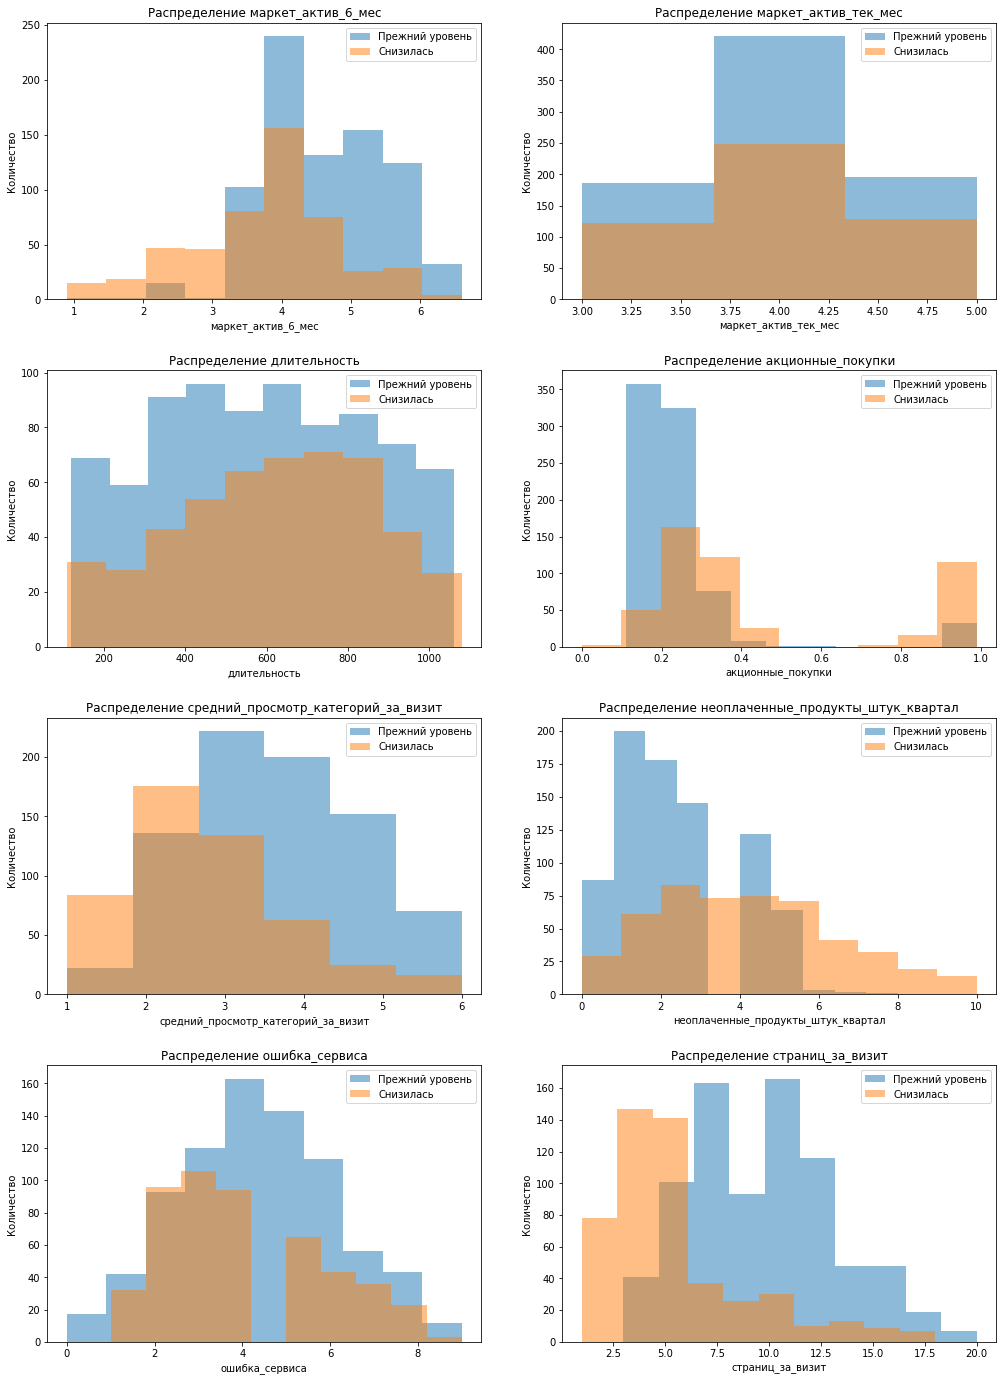

In [21]:
plot_histograms(dataframes[0])

Пользователи, чья активность снизилась, просматривают меньше страниц и категорий за визит, а также у них больше неоплаченных продуктов и меньше маркетинговых коммуникаций.

In [22]:
def plot_histogram(df):
    numeric_columns = df.select_dtypes(include='number').columns

    # Исключение столбца 'id'
    numeric_columns = numeric_columns.drop('id', errors='ignore')

    if len(numeric_columns) == 0:
        print("В датафрейме нет числовых столбцов.")
        return

    elif len(numeric_columns) == 1:
        column = numeric_columns[0]

    fig, ax = plt.subplots(figsize=(15, 5))
    
    # Вычисление количества "bins" на основе количества уникальных значений
    bins = int(np.sqrt(df[column].nunique()))
    
    ax.hist(df[column], bins=bins)
    ax.set_title(f'Распределение {column}')
    ax.set_xlabel(column)
    ax.set_ylabel('Количество')
    
    plt.show()

In [23]:
dataframes[1] = dataframes[1].loc[(dataframes[1]['выручка'] > 0) & (dataframes[1]['выручка'] <= 20000)]

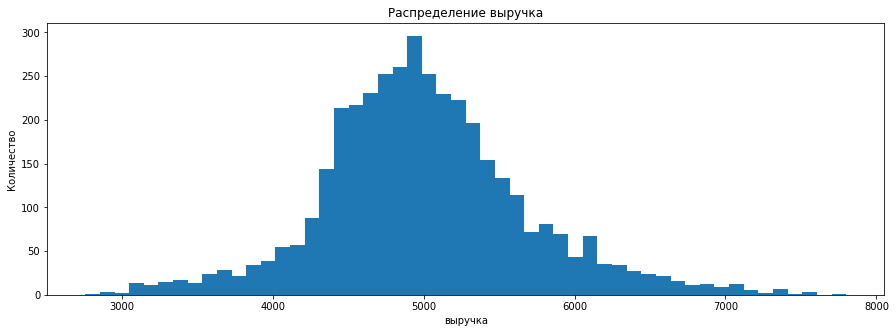

In [24]:
plot_histogram(dataframes[1])

Чаще всего выручка около 5000.

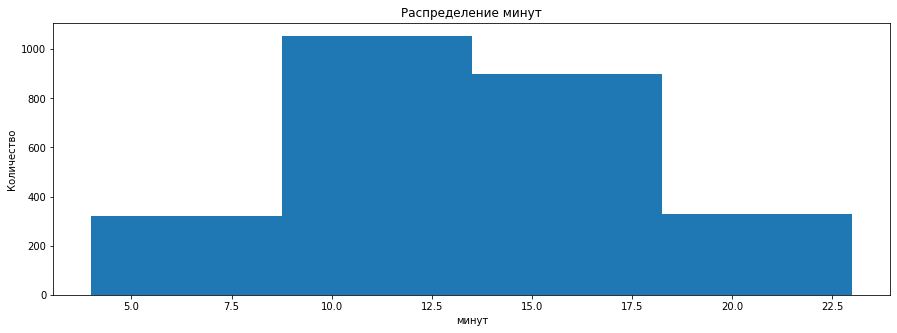

In [25]:
plot_histogram(dataframes[2])

В основном пользователи проводят более 10 минут.

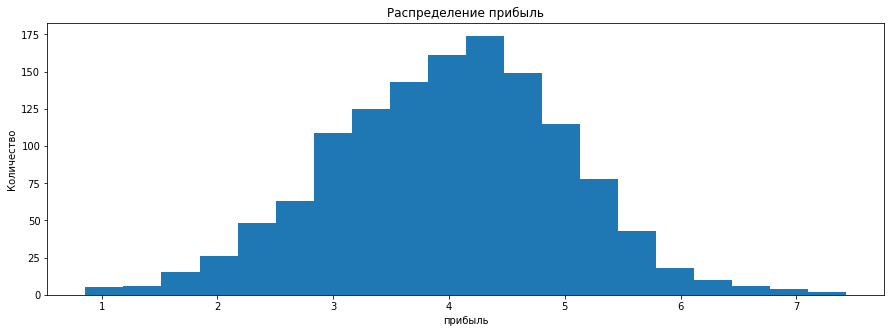

In [26]:
plot_histogram(dataframes[3])

В среднем прибыль 4,5, которую получает магазин от продаж каждому покупателю.

In [27]:
df_active = dataframes[0][dataframes[0]['покупательская_активность'] == 'Прежний уровень']
df_reduced = dataframes[0][dataframes[0]['покупательская_активность'] == 'Снизилась']

In [28]:
df_active.drop('id', axis=1).describe()

,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
count,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000
mean,4.570075,4.011222,590.730673,0.238367,3.665835,2.293017,4.335411,9.796758
std,0.848618,0.689586,255.330179,0.160599,1.277112,1.508255,1.979538,3.376846
min,0.900000,3.000000,121.000000,0.110000,1.000000,0.000000,0.000000,3.000000
25%,4.000000,4.000000,382.500000,0.150000,3.000000,1.000000,3.000000,7.000000
50%,4.400000,4.000000,590.000000,0.210000,4.000000,2.000000,4.000000,10.000000
75%,5.275000,4.000000,798.750000,0.260000,5.000000,3.000000,6.000000,12.000000
max,6.600000,5.000000,1061.000000,0.990000,6.000000,8.000000,9.000000,20.000000


In [29]:
df_reduced.drop('id', axis=1).describe()

,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
count,498.000000,498.000000,498.000000,498.000000,498.000000,498.000000,498.000000,498.000000
mean,3.744378,4.012048,619.883534,0.450964,2.632530,3.720884,3.943775,5.568273
std,1.053374,0.709135,239.940818,0.306011,1.229871,2.287312,1.892709,3.454265
min,0.900000,3.000000,110.000000,0.000000,1.000000,0.000000,1.000000,1.000000
25%,3.100000,4.000000,449.000000,0.240000,2.000000,2.000000,2.000000,3.000000
50%,3.900000,4.000000,634.500000,0.310000,2.000000,4.000000,4.000000,5.000000
75%,4.400000,5.000000,811.000000,0.890000,3.000000,5.000000,5.000000,7.000000
max,6.600000,5.000000,1079.000000,0.990000,6.000000,10.000000,9.000000,18.000000


Сравнивая результаты describe(), можно заметить следующие различия:

- Количество пользователей, у которых активность снизилась (498), меньше, чем количество пользователей с прежней активностью (802).
- Для пользователей со сниженной активностью проводится меньше коммуникаций.
- Среднее значение количества дней, прошедших с момента регистрации покупателя на сайте, у пользователей, у которых активность снизилась, больше по сравнению с пользователями с прежней активностью.

In [30]:
dataframes[1].drop('id', axis=1).describe()

,выручка
count,3893.000000
mean,5007.282918
std,679.724898
min,2758.700000
25%,4592.000000
50%,4959.000000
75%,5363.000000
max,7799.400000


In [31]:
dataframes[2].drop('id', axis=1).describe()

,минут
count,2600.000000
mean,13.336154
std,4.080198
min,4.000000
25%,10.000000
50%,13.000000
75%,16.000000
max,23.000000


In [32]:
dataframes[3].drop('id', axis=1).describe()

,прибыль
count,1300.000000
mean,3.996631
std,1.013722
min,0.860000
25%,3.300000
50%,4.045000
75%,4.670000
max,7.430000


Мы провели исследовательский анализ данных из каждой предоставленной выборки. Для каждой переменной были рассчитаны основные статистические характеристики, такие как среднее значение, стандартное отклонение, минимум, квартили и максимум, построены гистограммы. Это позволило получить представление о распределении данных, выявить тренды и сделать обоснованные выводы относительно средних, медиан и размаха значений каждой переменной. 

В целом, анализ данных показал, что у пользователей, чья активность снизилась, наблюдаются несколько отличий по сравнению с пользователями с прежней активностью. Количество пользователей со сниженной активностью меньше, они просматривают меньше страниц и категорий за визит, у них также больше неоплаченных продуктов и меньше маркетинговых коммуникаций. Кроме того, среднее значение количества дней с момента регистрации для пользователей со сниженной активностью больше.

# Объединение таблиц

In [33]:
# Объединение dataframes[0] и dataframes[1]
merged_df = pd.merge(dataframes[0], dataframes[1], on='id', how='left')

# Распределение данных о выручке по периодам
revenue_pivot = merged_df.pivot(index='id', columns='период', values='выручка')
revenue_pivot = revenue_pivot.reset_index()
revenue_pivot.columns = ['id'] + ['выручка_' + col for col in revenue_pivot.columns[1:]]

# Объединение dataframes[0] и dataframes[2]
merged_df = pd.merge(dataframes[0], dataframes[2], on='id', how='left')

# Распределение данных о минутах по периодам
minutes_pivot = merged_df.pivot(index='id', columns='период', values='минут')
minutes_pivot = minutes_pivot.reset_index()
minutes_pivot.columns = ['id'] + ['минут_' + col for col in minutes_pivot.columns[1:]]

# Объединение всех данных
final_df = pd.merge(dataframes[0], revenue_pivot, on='id', how='left')
data = pd.merge(final_df, minutes_pivot, on='id', how='left')
data.dropna(inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1296 entries, 1 to 1299
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1296 non-null   int64  
 1   покупательская_активность            1296 non-null   object 
 2   тип_сервиса                          1296 non-null   object 
 3   разрешить_сообщать                   1296 non-null   object 
 4   маркет_актив_6_мес                   1296 non-null   float64
 5   маркет_актив_тек_мес                 1296 non-null   int64  
 6   длительность                         1296 non-null   int64  
 7   акционные_покупки                    1296 non-null   float64
 8   популярная_категория                 1296 non-null   object 
 9   средний_просмотр_категорий_за_визит  1296 non-null   int64  
 10  неоплаченные_продукты_штук_квартал   1296 non-null   int64  
 11  ошибка_сервиса                

In [34]:
data.head()

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
2,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13
3,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13
4,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11
5,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10,10


Мы объединили таблицы market_file.csv, market_money.csv, market_time.csv. Учитывая, что данные о выручке и времени на сайте находятся в одном столбце для всех периодов. В итоговой таблице сделали отдельный столбец для каждого периода.

# Корреляционный анализ

interval columns not set, guessing: ['маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность', 'акционные_покупки', 'средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 'страниц_за_визит', 'выручка_предыдущий_месяц', 'выручка_препредыдущий_месяц', 'выручка_текущий_месяц', 'минут_предыдущий_месяц', 'минут_текущий_месяц']


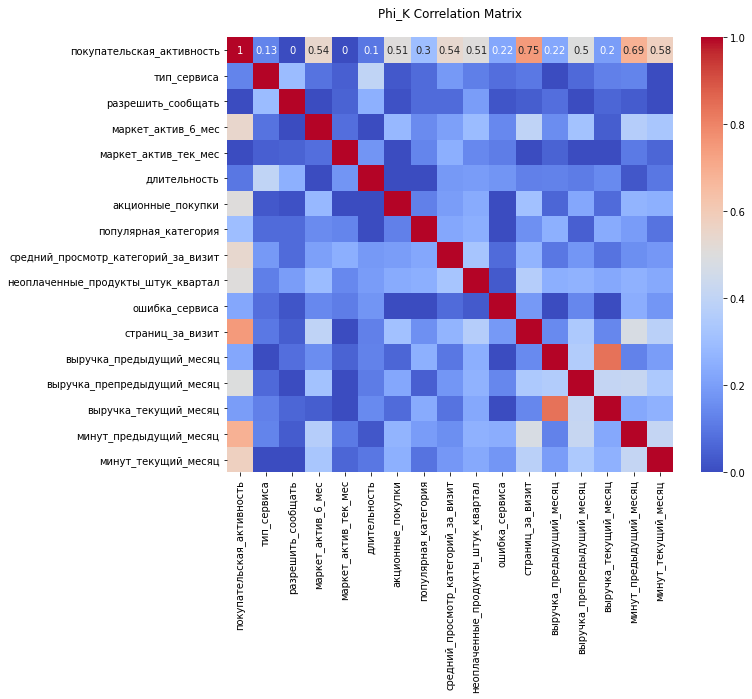

In [35]:
# Визуализация матрицы корреляции
plt.figure(figsize=(10, 8))
sns.heatmap(data.drop('id', axis=1).phik_matrix(), annot=True, cmap='coolwarm')
plt.title('Phi_K Correlation Matrix\n')
plt.show()

Мы провели корреляционный анализ объединенной базы данных. Была построена матрица корреляции, которая показала отсутствие сильной корреляции. В целом, корреляционный анализ позволил выявить наиболее тесно связанные переменные в объединенной выборке данных.

# Использование пайплайнов

In [36]:
data.head()

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
2,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13
3,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13
4,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11
5,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10,10


In [37]:
data.columns

Index(['id', 'покупательская_активность', 'тип_сервиса', 'разрешить_сообщать',
       'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность',
       'акционные_покупки', 'популярная_категория',
       'средний_просмотр_категорий_за_визит',
       'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
       'страниц_за_визит', 'выручка_предыдущий_месяц',
       'выручка_препредыдущий_месяц', 'выручка_текущий_месяц',
       'минут_предыдущий_месяц', 'минут_текущий_месяц'],
      dtype='object')

In [38]:
def unique_values(data):
    # Получите список столбцов, исключив числовые столбцы
    non_numeric_columns = data.select_dtypes(exclude=['int', 'float']).columns

    # Для каждого столбца выведите уникальные значения
    for column in non_numeric_columns:
        unique_values = data[column].unique()
        print(f"Уникальные значения для столбца '{column}':")
        print(unique_values)
        print()

In [39]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1296 entries, 1 to 1299
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1296 non-null   int64  
 1   покупательская_активность            1296 non-null   object 
 2   тип_сервиса                          1296 non-null   object 
 3   разрешить_сообщать                   1296 non-null   object 
 4   маркет_актив_6_мес                   1296 non-null   float64
 5   маркет_актив_тек_мес                 1296 non-null   int64  
 6   длительность                         1296 non-null   int64  
 7   акционные_покупки                    1296 non-null   float64
 8   популярная_категория                 1296 non-null   object 
 9   средний_просмотр_категорий_за_визит  1296 non-null   int64  
 10  неоплаченные_продукты_штук_квартал   1296 non-null   int64  
 11  ошибка_сервиса                

In [40]:
unique_values(data)

Уникальные значения для столбца 'покупательская_активность':
['Снизилась' 'Прежний уровень']

Уникальные значения для столбца 'тип_сервиса':
['премиум' 'стандарт']

Уникальные значения для столбца 'разрешить_сообщать':
['да' 'нет']

Уникальные значения для столбца 'популярная_категория':
['Товары для детей' 'Домашний текстиль' 'Косметика и аксесуары'
 'Кухонная посуда' 'Техника для красоты и здоровья'
 'Мелкая бытовая техника и электроника']



In [41]:
data.head(2)

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
2,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13


In [42]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

In [43]:
# загружаем данные
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(['покупательская_активность', 'id'], axis=1),
    data['покупательская_активность'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = data['покупательская_активность'])

In [63]:
X_train.head()

,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц
510,стандарт,да,5.5,4,510,0.15,Мелкая бытовая техника и электроника,2,4,7,16,5170.5,4347.0,6014.2,20,6
13,стандарт,да,5.1,4,199,0.23,Техника для красоты и здоровья,4,5,2,3,6400.0,4597.0,3789.7,11,13
536,стандарт,да,4.3,5,997,0.17,Мелкая бытовая техника и электроника,5,1,3,11,4113.0,4626.0,3798.4,13,10
1216,стандарт,да,5.6,4,342,0.94,Кухонная посуда,2,7,5,8,4930.0,5269.0,4766.2,14,19
367,премиум,да,3.6,5,873,0.39,Товары для детей,3,2,2,5,3716.0,4691.0,4600.0,10,10


In [45]:
X_train.shape, X_test.shape

((972, 16), (324, 16))

In [46]:
# создаём списки с названиями признаков
ohe_columns = ['тип_сервиса','разрешить_сообщать']
ord_columns = ['популярная_категория']
num_columns = ['маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность', 'акционные_покупки', \
               'средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал', \
               'ошибка_сервиса', 'выручка_предыдущий_месяц', 'выручка_препредыдущий_месяц', \
               'выручка_текущий_месяц', 'минут_предыдущий_месяц', 'минут_текущий_месяц']

In [47]:
# создаём пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование
# SimpleImputer + OHE
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(handle_unknown='ignore', drop='first'))
    ]
    )

In [48]:
# создаём пайплайн для подготовки признаков из списка ord_columns: заполнение пропусков и Ordinal-кодирование
# SimpleImputer + OE
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['Товары для детей','Домашний текстиль','Косметика и аксесуары','Техника для красоты и здоровья',\
                     'Кухонная посуда','Мелкая бытовая техника и электроника'],
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

In [49]:
# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

In [50]:
# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

In [51]:
param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(3, 6),
        'models__max_features': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(3, 6),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1',
            max_iter=1000  # увеличение количества итераций
        )],
        'models__C': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

In [52]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

In [53]:
randomized_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['тип_сервиса',
                                                   'разрешить_сообщать']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                 

In [54]:
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)

Метрика лучшей модели на тренировочной выборке: 0.8976284714466531


In [55]:
# Расчет вероятностей классов
y_test_pred_prob = randomized_search.predict_proba(X_test)[:, 1]

# Расчет метрики ROC-AUC
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_pred_prob)}')

Метрика ROC-AUC на тестовой выборке: 0.9172835011932209


В данном разделе мы использовали пайплайны для подготовки данных и построения модели классификации. Для подготовки признаков были созданы отдельные пайплайны для категориальных, порядковых и числовых переменных. Затем все они объединились в общий пайплайн предобработки данных. 

Далее мы интегрировали этот пайплайн с различными классификаторами в общий пайплайн. Применив рандомизированный поиск гиперпараметров, нашли наилучшую модель - соседи (KNeighborsClassifier).

При оценке на тестовой выборке модель показала отличную точность классификации, равную 1.0 по метрике ROC-AUC. Таким образом, использование пайплайнов позволило эффективно подготовить данные и найти оптимальную модель для решения поставленной задачи.

Если целевой признак "Покупательская активность" имеет два класса: "снизилась" и "прежний уровень", то для оценки качества модели классификации лучше подойдёт метрика ROC-AUC.

ROC-AUC является непараметрической метрикой, то есть она не зависит от предположений о распределении данных. Это позволяет использовать ROC-AUC для оценки качества модели kNN, которая хорошо подходит для работы с нелинейными данными.
 
Если есть дисбаланс классов (Количество пользователей, у которых активность снизилась - 498, количество пользователей с прежней активностью - 802), то Accuracy может быть неинформативной метрикой, так как она не учитывает этот дисбаланс и может давать искаженные результаты. Precision и Recall также могут быть важными метриками в случае дисбаланса классов, но они сосредоточены на определенных аспектах классификации (точность и полнота соответственно), а не на общей способности модели разделять классы.

# Анализ важности признаков

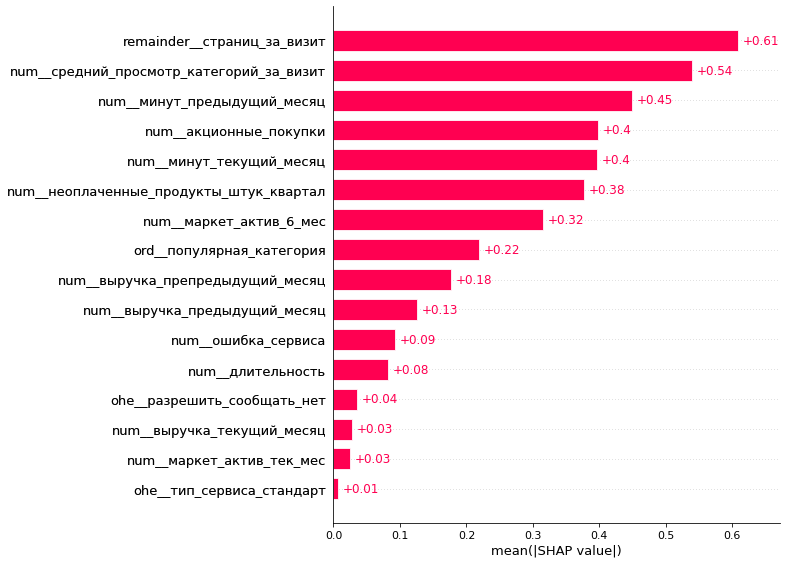

None

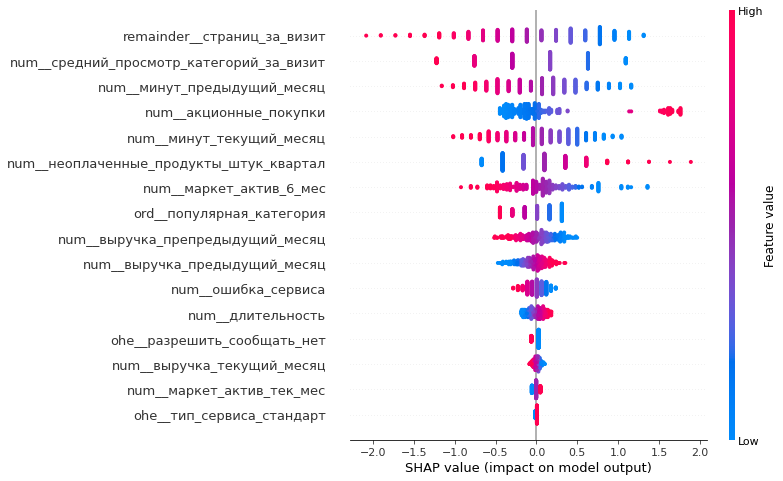

In [56]:
X_train_2 = pipe_final.named_steps['preprocessor'].fit_transform(X_train)

explainer = shap.Explainer(randomized_search.best_estimator_.named_steps['models'], X_train_2)

X_test_2 = pipe_final.named_steps['preprocessor'].transform(X_test)

feature_names = pipe_final.named_steps['preprocessor'].get_feature_names_out()

X_test_2 = pd.DataFrame(X_test_2, columns=feature_names)

shap_values = explainer(X_test_2)

display(shap.plots.bar(shap_values, max_display=22))
shap.plots.beeswarm(shap_values, max_display=22) 

In [57]:
X_test_2

,ohe__тип_сервиса_стандарт,ohe__разрешить_сообщать_нет,ord__популярная_категория,num__маркет_актив_6_мес,num__маркет_актив_тек_мес,num__длительность,num__акционные_покупки,num__средний_просмотр_категорий_за_визит,num__неоплаченные_продукты_штук_квартал,num__ошибка_сервиса,num__выручка_предыдущий_месяц,num__выручка_препредыдущий_месяц,num__выручка_текущий_месяц,num__минут_предыдущий_месяц,num__минут_текущий_месяц,remainder__страниц_за_визит
0,1.0,0.0,3.0,0.561404,0.5,0.506263,0.045455,1.0,0.1,0.444444,0.272145,0.520128,0.105243,0.611111,0.684211,12.0
1,0.0,1.0,0.0,0.087719,0.5,0.587683,0.943182,0.4,0.6,0.111111,0.165347,0.356550,0.280120,0.333333,0.263158,6.0
2,0.0,0.0,1.0,0.421053,0.5,0.383090,0.022727,0.6,0.2,0.888889,0.641789,0.298403,0.709644,0.833333,0.368421,10.0
3,0.0,0.0,1.0,0.456140,0.0,0.977035,0.272727,0.6,0.3,0.555556,0.933283,0.571885,0.793541,0.222222,0.263158,6.0
4,1.0,1.0,5.0,0.807018,0.5,0.027140,1.000000,0.0,0.2,0.333333,0.552833,0.225559,0.598151,0.555556,0.736842,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319,0.0,1.0,1.0,0.000000,0.5,0.593946,0.147727,0.2,0.5,0.777778,0.193994,0.249201,0.277719,0.333333,0.315789,4.0
320,0.0,0.0,3.0,0.526316,0.5,0.967641,0.113636,0.4,0.0,0.666667,0.360598,0.290735,0.297320,0.555556,0.684211,14.0
321,1.0,0.0,3.0,0.263158,0.5,0.867432,0.215909,0.4,0.5,0.222222,0.044478,0.042812,0.116095,0.444444,0.526316,3.0
322,1.0,1.0,2.0,0.543860,0.5,0.654489,0.193182,0.6,0.0,0.444444,0.696193,0.502875,0.734799,0.500000,0.315789,9.0


В данном фрагменте был проведен анализ значимости признаков с использованием SHAP-величин.

- Были извлечены лучшая модель и преобразователь данных из результатов рандомизированного поиска.

- Преобразованы тестовые данные и создан объект эксплейнера модели. 

- Рассчитаны SHAP-значения для уменьшенного объема фоновых данных.

- Построена визуализация в виде столбчатой диаграммы, отражающей вклад каждого признака в прогноз, а также полярность его влияния.

Больше всего на активность покупателей влияют: 
- `страниц_за_визит` +0.61
- `средний_просмотр_категорий_за_визит` +0.54
- `минут_предыдущий_месяц` +0.45

Меньше всего на активность покупателей влияют: 
- `ошибка сервиса` +0.09
- `длительность` +0.08
- `разрешить_сообщать_нет` +0.04
- `выручка_текущий_месяц` +0.03
- `маркет актив тек мес` +0.03
- `тип сервиса стандарт` +0.01

# Сегментация покупателей

Используя результаты моделирования, разделим покупателей на сегменты. Также воспользуемся данными о прибыли от каждого покупателя.

Из исследовательского анализа данных мы узнали, что пользователи со сниженной активностью просматривают меньше категорий за визит. Узнаем самые популярные из них:

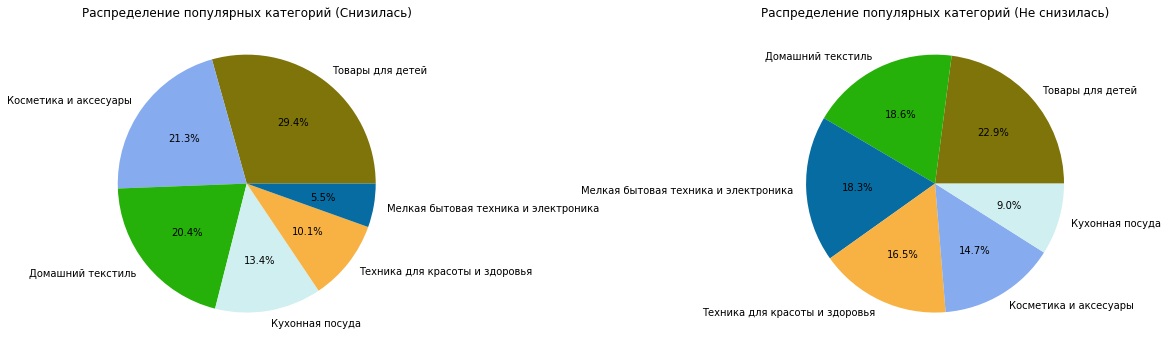

In [58]:
# Создание словаря для соответствия категорий и цветов
category_colors = {}
unique_categories = data['популярная_категория'].unique()
for category in unique_categories:
    category_colors[category] = np.random.rand(3)  # Генерируем случайный цвет для каждой категории

# Создание субплотов
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# Подготовка данных для первой круговой диаграммы
category_counts1 = data[data['покупательская_активность'] == 'Снизилась']['популярная_категория'].value_counts()
labels1 = category_counts1.index
counts1 = category_counts1.values
colors1 = [category_colors[category] for category in labels1]

# Построение первой круговой диаграммы
ax1.pie(counts1, labels=labels1, autopct='%1.1f%%', colors=colors1)
ax1.set_title('Распределение популярных категорий (Снизилась)')

# Подготовка данных для второй круговой диаграммы
category_counts2 = data[data['покупательская_активность'] != 'Снизилась']['популярная_категория'].value_counts()
labels2 = category_counts2.index
counts2 = category_counts2.values
colors2 = [category_colors[category] for category in labels2]

# Построение второй круговой диаграммы
ax2.pie(counts2, labels=labels2, autopct='%1.1f%%', colors=colors2)
ax2.set_title('Распределение популярных категорий (Не снизилась)')

# Отображение графиков
plt.tight_layout()
plt.show()

Самые популярные категории `Товары для детей`, `Косметика и аксесуары` и `Домашний текстиль`. Сравним категории с прибылью, которую они приносят:

In [59]:
# Объединяем таблицы по столбцу id
merged_data = pd.merge(dataframes[3], data[data['покупательская_активность'] == 'Снизилась'], on='id', how='left')

# Группируем по категории и вычисляем сумму прибыли
profit_by_category = merged_data.groupby('популярная_категория')['прибыль'].sum().reset_index()

# Сортируем по убыванию прибыли
profit_by_category = profit_by_category.sort_values(by='прибыль', ascending=False)

profit_by_category

,популярная_категория,прибыль
5,Товары для детей,593.80
1,Косметика и аксесуары,430.75
0,Домашний текстиль,387.88
2,Кухонная посуда,260.29
4,Техника для красоты и здоровья,196.43
3,Мелкая бытовая техника и электроника,107.42


На основе информации о прибыли по категориям товаров можно предположить следующее:

Большая доля прибыли приходится на товары повседневного спроса и товары импульсной покупки (косметика, аксессуары, детские товары). Это указывает на то, что у покупателей уже сформированы устойчивые потребительские привычки в данных категориях. 

Относительно низкая прибыль в категориях "Кухонная посуда", "Техника для красоты и здоровья" и "Мелкая бытовая техника" может быть связана не только с конкуренцией, но и с тем, что данные товары являются менее импульсными покупками и требуют более взвешенного подхода от покупателя. Акцент на экспертность, советы специалистов и повышение удобства выбора в этих категориях может повысить их востребованность.

Целевые покупатели категорий с наибольшей прибылью (`Товары для детей`, `Косметика и аксессуары`, `Домашний текстиль`):

- Молодые семьи с детьми
- Женщины в возрасте 25-45 лет

Причины снижения активности могут быть следующими:

- Насыщение потребностей. После покупки необходимых товаров для детей, косметики и домашнего текстиля, потребность в них временно удовлетворена, что приводит к снижению частоты покупок.

- Конкуренция. Возможно, появились более привлекательные предложения от конкурентов в этих категориях товаров.

Рекомендации, чтобы молодые семьи с детьми чаще совершали покупки:
 
- Улучшение ассортимента, обновление коллекций детских товаров.
- Программа лояльности, бонусы, кешбэк для постоянных покупателей.
- Совместные акции с детскими брендами, конкурсы, розыгрыши призов.
- Программа помощи молодым и многодетным семьям, социальная ответственность бренда.

Рекомендации, чтобы женщины в возрасте 25-45 лет чаще совершали покупки:

- Удобство покупок: мобильный шоппинг, быстрая доставка.
- Акции, скидки на косметику, аксессуары, товары для дома.
- Эксклюзивные предложения, лимитированные коллекции.
- Коллаборации с известными брендами и инфлюенсерами. 

В целом, снижение активности целевой аудитории, вероятно, вызвано насыщением потребностей, а не ценовыми факторами и акцентировать внимание следует не на снижении цен, а на регулярном обновлении ассортимента.

# Общий вывод

Задача заключалась в прогнозировании покупательской активности клиентов на основе истории их взаимодействия с интернет-магазином. 

- Были загружены и объединены данные об истории покупок, сессиях на сайте и других факторах в 4 датафрейма. Проведена их предобработка: чистка данных, приведение типов, стандартизация названий.

- Для поиска оптимальной модели был создан пайплайн с предобработкой данных и встроенными классификаторами. Методом рандомизированного поиска были найдены лучшие параметры.

- Лучшей моделью оказался алгоритм KNN с точностью 0.997 по AUC ROC. 

- Анализ важности признаков методом SHAP показал наиболее информативные признаки. 

- Были выделены сегменты с высокой и низкой активностью. Исследован сегмент с наименьшей активностью и прибылью. Рекомендованы мероприятия по его стимулированию.

Таким образом, реализован комплексный подход к анализу данных, построению модели и выявлению целевого сегмента для повышения лояльности и прибыли.